<a href="https://colab.research.google.com/github/zmunilla/TFM/blob/main/8_Triplet_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1-CONECTAR CON GOOGLE DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2- CARGAR LIBRERÍAS

In [2]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np

3-FUNCIÓN DE REDIMENSIONAR SIN DEFORMAR

In [3]:
#creo la función para que las imágenes de recortes se redimensionen sin estirar la
#imagen

from torchvision.transforms import functional as TF

class ResizeWithPadding:
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        target_h, target_w = self.size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)

        img = TF.resize(img, (new_h, new_w))

        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        pad_right = target_w - new_w - pad_left
        pad_bottom = target_h - new_h - pad_top

        img = TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img

#los bordes de las imágenes que hay que rellenar para completar el tamaño se rellenan
#con color negro

4- CONFIGURAR PARAMETROS Y TRANSFORMACIONES

In [6]:

train_dir = '/content/drive/MyDrive/TFM/Cat_dataset/right_2/train'
test_dir = '/content/drive/MyDrive/TFM/Cat_dataset/right_2/test'
batch_size = 32
num_epochs = 60
embedding_dim = 2048  # Tamaño del embedding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRANSFORMACIONES

resize_pad = ResizeWithPadding((224, 224)) #redimensionamos a 224x224

train_transform = transforms.Compose([ #con aumentación de datos
    resize_pad,
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, shear=5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    resize_pad,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform = test_transform #para usar luego con las nuevas imágenes de prueba

5- FUNCION CREACION TRIPLETES

In [4]:
class TripletDataset(Dataset): #Se crea la clase para creación de tripletes
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform #transformaciones a aplicar

        # Se cargan las clases que tienen al menos dos imágenes para tener anchor
        #y positivo distintos
        self.classes = [cls for cls in os.listdir(root_dir)
                        if len(os.listdir(os.path.join(root_dir, cls))) >= 2]

        self.class_to_images = {
            cls: os.listdir(os.path.join(root_dir, cls))
            for cls in self.classes
        }

        self.image_list = [(cls, img) for cls in self.classes
                           for img in self.class_to_images[cls]]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Anchor
        anchor_class, anchor_img = self.image_list[idx]
        positive_class = anchor_class

        # Seleccionar imagen positiva distinta a Anchor
        positive_img = random.choice([
            img for img in self.class_to_images[positive_class]
            if img != anchor_img
        ])

        # Negativa de otra clase
        negative_class = random.choice([cls for cls in self.classes if cls != anchor_class])
        negative_img = random.choice(self.class_to_images[negative_class])

        # Cargar imágenes
        anchor_path = os.path.join(self.root_dir, anchor_class, anchor_img)
        positive_path = os.path.join(self.root_dir, positive_class, positive_img)
        negative_path = os.path.join(self.root_dir, negative_class, negative_img)

        anchor = Image.open(anchor_path).convert('RGB')
        positive = Image.open(positive_path).convert('RGB')
        negative = Image.open(negative_path).convert('RGB')

        if self.transform: #se aplican las transformaciones
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative #devuelve los tripletes


6- DATASETS Y DATALOADERS

In [7]:
# MODELO BASE RESNET50 CON DIMENSIÓN EMBEDDING = 2048 Y MARGIN=1

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=2048, normalize=True):
        super(EmbeddingNet, self).__init__()
        self.normalize = normalize
        self.backbone = models.resnet50(weights='IMAGENET1K_V1')

        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, embedding_dim) #Se reemplaza la capa final
        #por otra con salida de dimensión igual a la del vector de características

    def forward(self, x):
        x = self.backbone(x)
        if self.normalize:
            x = F.normalize(x, p=2, dim=1) #se normaliza el embedding para poder usarlo con Triplet Loss
        return x


# TRIPLET LOSS
triplet_loss = nn.TripletMarginLoss(margin=1, p=2) #En este caso la función está predefinida en
#Pytorch

# DATASETS Y DATALOADERS

train_dataset = TripletDataset(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TripletDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

7- ENTRENAMIENTO MODELO

Epoch [1/60] - Loss: 0.9470 - Val Loss: 0.8822 - Test Acc: 0.8056
Epoch [2/60] - Loss: 0.8393 - Val Loss: 0.8747 - Test Acc: 0.8056
Epoch [3/60] - Loss: 0.6606 - Val Loss: 0.6375 - Test Acc: 0.7500
Epoch [4/60] - Loss: 0.5328 - Val Loss: 0.7467 - Test Acc: 0.6944
Epoch [5/60] - Loss: 0.4269 - Val Loss: 0.6418 - Test Acc: 0.7778
Epoch [6/60] - Loss: 0.3334 - Val Loss: 0.6808 - Test Acc: 0.8333
Epoch [7/60] - Loss: 0.2703 - Val Loss: 0.6590 - Test Acc: 0.7778
Epoch [8/60] - Loss: 0.2822 - Val Loss: 0.6536 - Test Acc: 0.8611
Epoch [9/60] - Loss: 0.2370 - Val Loss: 0.7390 - Test Acc: 0.8056
Epoch [10/60] - Loss: 0.1801 - Val Loss: 0.8664 - Test Acc: 0.8056
Epoch [11/60] - Loss: 0.1649 - Val Loss: 0.8884 - Test Acc: 0.7500
Epoch [12/60] - Loss: 0.1392 - Val Loss: 0.8495 - Test Acc: 0.8333
Epoch [13/60] - Loss: 0.1544 - Val Loss: 0.9391 - Test Acc: 0.8333
Epoch [14/60] - Loss: 0.1793 - Val Loss: 0.8334 - Test Acc: 0.8333
Epoch [15/60] - Loss: 0.0959 - Val Loss: 0.6618 - Test Acc: 0.8333
Epoc

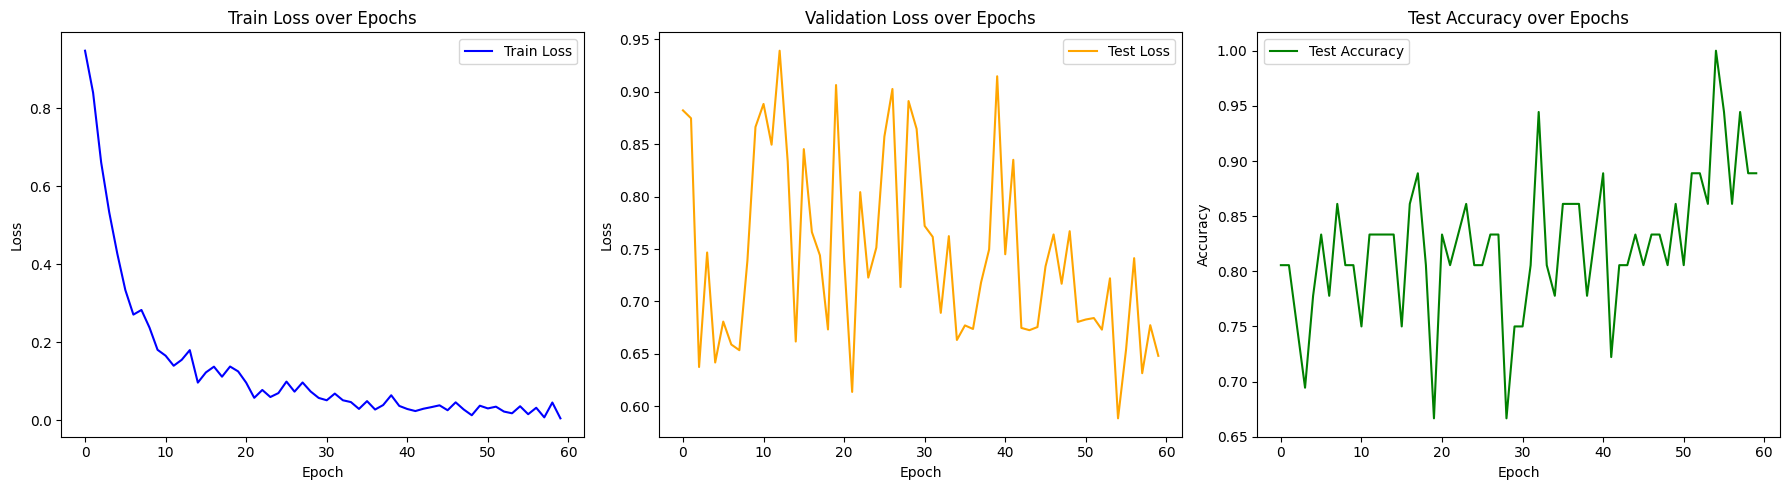

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# INICIALIZAR MODELO

model = EmbeddingNet(embedding_dim=2048).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# CREAMOS LISTAS DE MÉTRICAS

train_losses = []
test_accuracies = []
val_losses = []

# VARIABLES DE DESEMPEÑO DEL MODELO

best_accuracy = 0.0
best_model_state = None
best_optimizer_state = None
best_epoch = 0
best_loss = float('inf')



def evaluate(model, loader, loss_fn): #Función de evaluación del entrenamiento
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for anchor, positive, negative in loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)

            # Accuracy
            dist_pos = torch.norm(anchor_emb - positive_emb, p=2, dim=1)
            dist_neg = torch.norm(anchor_emb - negative_emb, p=2, dim=1)
            correct += torch.sum(dist_pos < dist_neg).item()
            total += anchor.size(0)

            # Loss
            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            val_loss += loss.item()

    accuracy = correct / total
    avg_val_loss = val_loss / len(loader)
    return accuracy, avg_val_loss


# ENTRENAMIENTO

for epoch in range(num_epochs):
    model.train() #pasamos el modelo a modo entrenamiento
    running_loss = 0.0

    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        loss = triplet_loss(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # EVALUACIÓN CON FUNCIÓN YA DEFINIDA

    test_acc, val_loss = evaluate(model, test_loader, triplet_loss)
    test_accuracies.append(test_acc)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f} - Test Acc: {test_acc:.4f}')

    # DEFINIMOS CUÁL ES EL MEJOR MODELO EN BASE A PRECISIÓN DEL TEST Y EN CASO DE EMPATE A LA MENOR PÉRDIDA

    if (test_acc > best_accuracy) or (test_acc == best_accuracy and epoch_loss < best_loss):
        best_accuracy = test_acc
        best_loss = epoch_loss
        best_model_state = model.state_dict()
        best_optimizer_state = optimizer.state_dict()
        best_epoch = epoch

# GUARDAMOS EL MEJOR MODELO CON TORCH.SAVE

save_path = f'/content/drive/MyDrive/TFM/modelos2/best_triplet_model_right_def2048_1_60.pth'
torch.save({
    'epoch': best_epoch,
    'model_state_dict': best_model_state,
    'optimizer_state_dict': best_optimizer_state,
    'best_accuracy': best_accuracy
}, save_path)

print(f'Mejor modelo guardado en {save_path} con precisión {best_accuracy:.4f} en la época {best_epoch+1}')

# GRÁFICAS

plt.figure(figsize=(18, 5))

# Pérdida de entrenamiento
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()

# Pérdida en test
plt.subplot(1, 3, 2)
plt.plot(val_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

# Precisión
plt.subplot(1, 3, 3)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()



8-ALMACENAMIENTO DE MÉTRICAS POR ÉPOCA

In [ ]:
#ALMACENAMOS LAS MÉTRICAS PARA PODER USARLAS POSTERIORMENTE

import pandas as pd

# Crear DataFrame con las métricas

metrics_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs + 1)),
    'Train Loss': train_losses,
    'Test Loss': val_losses,
    'Test Accuracy': test_accuracies
})

metrics_df = metrics_df.round(4)

print(metrics_df.head())

# Guardar como CSV
metrics_df.to_csv('/content/drive/MyDrive/TFM/metricas/metrics_triplet_training_right2048_1_60.csv', index=False)


   Epoch  Train Loss  Test Loss  Test Accuracy
0      1      0.9470     0.8822         0.8056
1      2      0.8393     0.8747         0.8056
2      3      0.6606     0.6375         0.7500
3      4      0.5328     0.7467         0.6944
4      5      0.4269     0.6418         0.7778


9-CREACIÓN EMBEDDINGS PROMEDIO CON TODAS LAS IMAGENES DISPONIBLES

In [9]:
import torch
import os
import pickle
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

def create_catalog_with_avg_embeddings_pkl(model, catalog_folder, transform, device, output_pkl_path):
    model.eval()
    catalog = {}  # Diccionario de almacenamiento

    for individual in os.listdir(catalog_folder):
        individual_path = os.path.join(catalog_folder, individual)
        if not os.path.isdir(individual_path):
            continue

        images = [f for f in os.listdir(individual_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(images) == 0:
            continue

        embeddings = []
        rep_image_bytes = None

        for idx, img_name in enumerate(images):
            img_path = os.path.join(individual_path, img_name)

            # Cargar imagen
            img = Image.open(img_path).convert('RGB')

            if idx == 0:
                # Guardamos una imagen representativa de cada clase
                from io import BytesIO
                buffer = BytesIO()
                img.save(buffer, format='JPEG')
                rep_image_bytes = buffer.getvalue()

            img_tensor = transform(img).unsqueeze(0).to(device)

            # Obtener embedding
            with torch.no_grad():
                embedding = model(img_tensor).squeeze(0).cpu()
                embeddings.append(embedding)

        # Calcular promedio de embeddings
        if embeddings:
            avg_embedding = torch.stack(embeddings).mean(dim=0)
            avg_embedding = F.normalize(avg_embedding, p=2, dim=0)

            catalog[individual] = {
                'embedding': avg_embedding,
                'image': rep_image_bytes  # Imagen representativa en bytes
            }

            print(f"Clase {individual}: embedding creado con imagen guardada.")

    # Guardar catálogo completo como .pkl
    with open(output_pkl_path, 'wb') as f:
        pickle.dump(catalog, f)

    print(f"\nCatálogo guardado en: {output_pkl_path}")


In [10]:
# CARGO EL MODELO

model = EmbeddingNet(embedding_dim=2048).to(device)

checkpoint = torch.load('/content/drive/MyDrive/TFM/modelos2/best_triplet_model_right_def2048_1_60.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# TRANSFORMACIÓN PARA IMAGENES INCÓGNITA

transform = transforms.Compose([
    resize_pad,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Definir rutas
catalog_folder = '/content/drive/MyDrive/TFM/Cat_dataset/right_2/train'
output_pkl_path = '/content/drive/MyDrive/TFM/modelos2/catalog_triplet_right2048_1_60_im.pkl'

# Crear catálogo
create_catalog_with_avg_embeddings_pkl(model, catalog_folder, transform, device, output_pkl_path)

Clase 001_R: embedding creado con imagen guardada.
Clase 002_R: embedding creado con imagen guardada.
Clase 003_R: embedding creado con imagen guardada.
Clase 004_R: embedding creado con imagen guardada.
Clase 006_R: embedding creado con imagen guardada.
Clase 007_R: embedding creado con imagen guardada.
Clase 008_R: embedding creado con imagen guardada.
Clase 014_R: embedding creado con imagen guardada.
Clase 016_R: embedding creado con imagen guardada.
Clase 018_R: embedding creado con imagen guardada.
Clase 021_R: embedding creado con imagen guardada.
Clase 022_R: embedding creado con imagen guardada.
Clase 026_R: embedding creado con imagen guardada.
Clase 028_R: embedding creado con imagen guardada.
Clase 029_R: embedding creado con imagen guardada.
Clase 030_R: embedding creado con imagen guardada.
Clase 031_R: embedding creado con imagen guardada.
Clase 032_R: embedding creado con imagen guardada.
Clase 035_R: embedding creado con imagen guardada.
Clase 036_R: embedding creado c

9-FUNCIONES PARA NUEVA IDENTIFICACIÓN DE IMAGEN CON ENFOQUE KNN

In [11]:
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F
import pickle
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def get_embedding(model, image_path, transform, device): #FUNCIÓN PARA CREAR EMBEDDINGS
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor).squeeze(0)
        embedding = F.normalize(embedding, p=2, dim=0)
    return embedding.cpu().numpy()

def find_top_k_sklearn(model, query_image_path, catalog_pkl_path, transform, device, k=5, metric='cosine'):
    # Cargar catálogo de embeddings
    with open(catalog_pkl_path, 'rb') as f:
        catalog = pickle.load(f)

    class_ids = list(catalog.keys())
    embeddings = np.stack([catalog[c]['embedding'].numpy() for c in class_ids])

    # Definir índice KNN
    knn = NearestNeighbors(n_neighbors=k, metric=metric)
    knn.fit(embeddings)

    # Obtener embedding de la imagen incógnita
    query_emb = get_embedding(model, query_image_path, transform, device).reshape(1, -1)

    # Buscar los k vecinos más cercanos
    distances, indices = knn.kneighbors(query_emb)

    # Resultados
    top_k = []
    for i, idx in enumerate(indices[0]):
        class_id = class_ids[idx]
        img_bytes = catalog[class_id]['image']
        score = 1 - distances[0][i] if metric == 'cosine' else -distances[0][i]
        top_k.append((class_id, score, img_bytes))

    # Visualización con las imágenes de la predicción
    fig, axes = plt.subplots(1, k + 1, figsize=(4 * (k + 1), 5))
    query_img = Image.open(query_image_path).convert('RGB')
    axes[0].imshow(query_img)
    axes[0].set_title("Imagen incógnita")
    axes[0].axis('off')

    for i, (class_id, score, img_bytes) in enumerate(top_k):
        img = Image.open(BytesIO(img_bytes))
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{class_id}\nScore: {score:.3f}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

    return top_k


10. USO DEL CÓDIGO

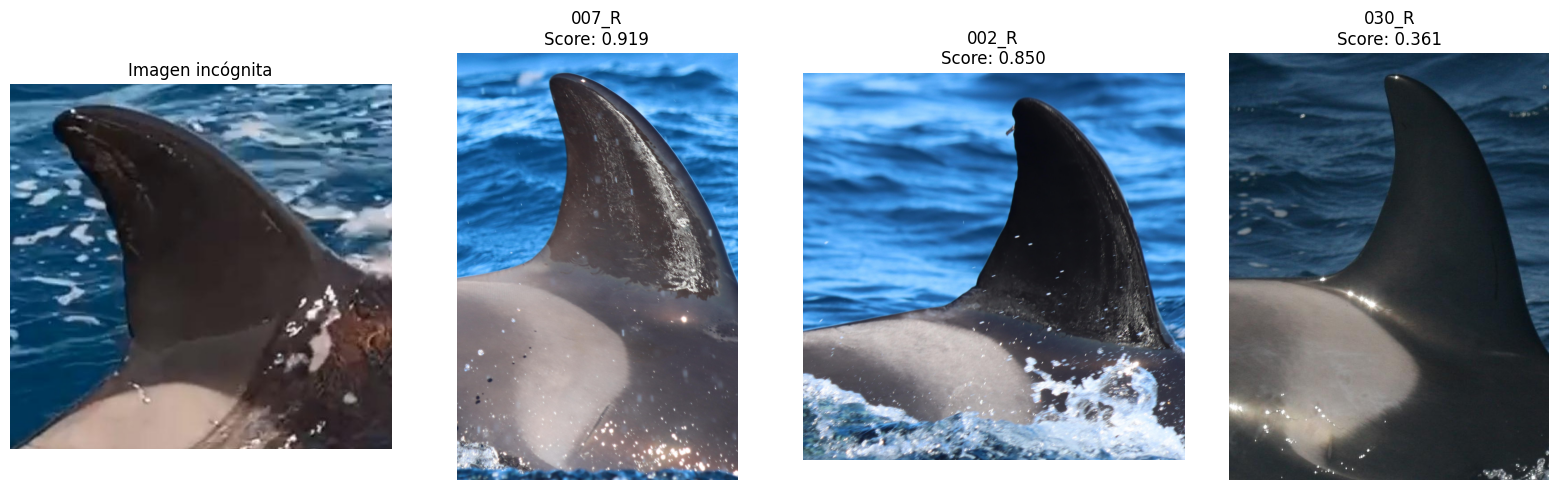

In [15]:
#uso

query_path = '/content/drive/MyDrive/TFM/Orca/orca_onix.jpg'
catalog_pkl = '/content/drive/MyDrive/TFM/modelos2/catalog_triplet_right2048_1_60_im.pkl'

top_k = find_top_k_sklearn(
    model,
    query_image_path=query_path,
    catalog_pkl_path=catalog_pkl,
    transform=transform,
    device=device,
    k=3,
    metric='cosine' #se puede cambiar por euclídea o por otra
)


11-PRECISIÓN CON DATOS TEST : TOP1 - TOP3 - TOP5 (KNN)

In [13]:
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F
from PIL import Image
import os
import pickle
import numpy as np

def get_embedding(model, image_path, transform, device): #función de creación de embeddings
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor).squeeze(0)
        embedding = F.normalize(embedding, p=2, dim=0)
    return embedding.cpu().numpy()

#definición función de cálculo de precisión

def calculate_topk_accuracy_with_knn(model, test_folder, catalog_pkl_path, transform, device, k_values=[1, 3, 5], metric='cosine'):
    model.eval()

    # Cargar catálogo
    with open(catalog_pkl_path, 'rb') as f:
        catalog = pickle.load(f)

    class_ids = list(catalog.keys())
    embeddings = np.stack([catalog[c]['embedding'].numpy() for c in class_ids])

    # Inicializar modelo KNN
    knn = NearestNeighbors(n_neighbors=max(k_values), metric=metric)
    knn.fit(embeddings)

    # Inicializar contadores
    correct_topk = {k: 0 for k in k_values}
    total = 0

    for individual in os.listdir(test_folder):
        individual_path = os.path.join(test_folder, individual)
        if not os.path.isdir(individual_path):
            continue

        image_files = [f for f in os.listdir(individual_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in image_files:
            img_path = os.path.join(individual_path, img_name)

            # Embedding de la imagen de test
            query_emb = get_embedding(model, img_path, transform, device).reshape(1, -1)

            # Buscar vecinos
            _, indices = knn.kneighbors(query_emb)

            # Obtener predicciones
            top_preds = [class_ids[i] for i in indices[0]]

            for k in k_values:
                if individual in top_preds[:k]:
                    correct_topk[k] += 1

            total += 1

    # Calcular precisión top-k

    accuracy_topk = {k: correct_topk[k] / total if total > 0 else 0.0 for k in k_values}
    return accuracy_topk


12. USO FUNCIÓN CÁLCULO PRECISIÓN EN TEST

In [14]:
test_folder = '/content/drive/MyDrive/TFM/Cat_dataset/right_2/test'
catalog_pkl = '/content/drive/MyDrive/TFM/modelos2/catalog_triplet_right2048_1_60_im.pkl'

accuracy_topk = calculate_topk_accuracy_with_knn(
    model=model,
    test_folder=test_folder,
    catalog_pkl_path=catalog_pkl,
    transform=transform,
    device=device,
    k_values=[1, 3, 5],
    metric='cosine'  # o 'cosine'
)

# Mostrar resultados
for k, acc in accuracy_topk.items():
    print(f"Precisión Top-{k}: {acc * 100:.2f}%")


Precisión Top-1: 63.41%
Precisión Top-3: 80.49%
Precisión Top-5: 82.93%


13-CODIGO PARA EVALUAR RESULTADOS POR INDIVIDUO Y GUARDAR ARCHIVO CSV

In [ ]:
#para poder valorar los individuos con peores resultados y mejorar sus carpetas de imágenes

from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F
from PIL import Image
import os
import csv
import pickle
import numpy as np

def get_embedding(model, image_path, transform, device):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        embedding = model(img_tensor).squeeze(0)
        embedding = F.normalize(embedding, p=2, dim=0)

    return embedding.cpu().numpy()

def evaluate_and_save_results_knn(model, test_folder, catalog_pkl_path, transform, device, output_csv):
    model.eval()
    results = []

    # Cargar catálogo
    with open(catalog_pkl_path, 'rb') as f:
        catalog = pickle.load(f)

    class_ids = list(catalog.keys())
    embeddings = np.stack([catalog[c]['embedding'].numpy() for c in class_ids])

    # Inicializar KNN
    knn = NearestNeighbors(n_neighbors=embeddings.shape[0], metric='cosine')
    knn.fit(embeddings)

    for individual in os.listdir(test_folder):
        individual_path = os.path.join(test_folder, individual)
        if not os.path.isdir(individual_path):
            continue

        image_files = [f for f in os.listdir(individual_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in image_files:
            img_path = os.path.join(individual_path, img_name)
            query_emb = get_embedding(model, img_path, transform, device).reshape(1, -1)

            distances, indices = knn.kneighbors(query_emb)

            predicted_ids = [class_ids[i] for i in indices[0]]

            top1_prediction = predicted_ids[0]
            is_correct_top1 = int(top1_prediction == individual)
            is_correct_top3 = int(individual in predicted_ids[:3])
            is_correct_top5 = int(individual in predicted_ids[:5])
            true_rank = predicted_ids.index(individual) + 1 if individual in predicted_ids else -1

            results.append({
                'Image': img_name,
                'True_Individual': individual,
                'Top1_Prediction': top1_prediction,
                'Top1_Correct': is_correct_top1,
                'Top3_Includes_True': is_correct_top3,
                'Top5_Includes_True': is_correct_top5,
                'True_Individual_Rank': true_rank
            })

    # Guardar CSV
    fieldnames = ['Image', 'True_Individual', 'Top1_Prediction', 'Top1_Correct',
                  'Top3_Includes_True', 'Top5_Includes_True', 'True_Individual_Rank']

    with open(output_csv, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)

    print(f"✅ Resultados guardados en {output_csv}")


In [ ]:
# USO

test_folder = '/content/drive/MyDrive/TFM/Cat_dataset/right_2/test'
catalog_pkl = '/content/drive/MyDrive/TFM/modelos2/catalog_triplet_right2048_1_60_im.pkl'
output_csv = '/content/drive/MyDrive/TFM/metricas/test_results_triplet_right_def2048_1_60_knn.csv'

evaluate_and_save_results_knn(
    model=model,
    test_folder=test_folder,
    catalog_pkl_path=catalog_pkl,
    transform=transform,
    device=device,
    output_csv=output_csv
)


✅ Resultados guardados en /content/drive/MyDrive/TFM/metricas/test_results_triplet_right_def2048_1_60_knn.csv
